In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# 70,000 x 784
X = X.values 
# 70,000 x 1 class labels
y = y.astype(int).values
print(X.shape)
print(y.shape)


(70000, 784)
(70000,)


In [3]:
# normalize pixel values from range -1 to 1
X = ((X/255.) - .5)*2

In [6]:
# divide into training, validation, and test subsets 
from sklearn.model_selection import train_test_split 
X_temp, X_test, y_temp, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size=10000, 
                                                  random_state=123,
                                                  stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, 
                                                      y_temp, 
                                                      test_size=5000, 
                                                      random_state=123, 
                                                      stratify=y_temp)
                                                      



In [5]:
import numpy as np
def sigmoid(z): 
    return 1./(1. + np.exp(-z))

# convert integer class label arrays to one-hot enncoded labels
def int_to_onehot(y, num_labels): 
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y): 
        ary[i, val] = 1
    return ary 

In [8]:
class NeuralNetMLP: 
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes 
        # hidden 
        rng = np.random.RandomState(random_seed) 
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden) 
        # output
        self.weight_out = rng.normal(loc=0.0, scale=1.0, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes) 
    
    def forward(self, x): 
        # hidden layer 
        # input dim:    [n_hidden, n_features] 
        #            dot[n_features, n_examples].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h) 

        # output layer 
        # input dim:    [n_classes, n_hidden]
        #            dot[n_hidden, n_examples].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out 
        a_out = sigmoid(z_out)
        return a_h, a_out 

    def backward(self, x, a_h, a_out, y): 
        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # part 1: dL/dw_out
        # = dL/da_out * da_out/dz_out * dz_out/d_w_out
        # where delta_out = dL/da_out * da_out/dz_out

        # input/output dim: [n_examples, n_classes]
        dl_da_out = 2.*(a_out - y_onehot)/y.shape[0]
        # input/output dim: [n_examples, n_classes]
        da_out_dz_out = a_out * (1. - a_out)    # sigmoid derivative
        # output dim: [n_examples, n_classes]
        delta_out = dl_da_out * da_out_dz_out 
        # gradient for output weights 

        #[n_examples, n_hidden]
        dz_out_dw_out = a_h

        # input dim:   [n_classes, n_examples]
        #           dot[n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        dl_dw_out = np.dot(delta_out.T, dz_out_dw_out)
        dl_db_out = np.sum(delta_out, axis=0) 

        ###
        # part 2: dL/dw_h
        # = delta_out * dz_out/da_h * da_h/dz_h * dz_h/dw

        # [n_classe, n_hidden]
        dz_out_a_h = self.weight_out 
        # output dim: [n_examples, n_hidden]
        dl_a_h = np.dot(delta_out, dz_out_a_h)
        # [n_examples, n_hidden]
        da_h_dz_h = a_h * (1. - a_h)        # sigmoid derivative
        # [n_examples, n_features]
        dz_h_dw_h = x 
        # output dim: [n_hidden, n_features]
        dl_dw_h = np.dot((dl_a_h * da_h_dz_h).T, dz_h_dw_h)
        dl_db_h = np.sum((dl_a_h * da_h_dz_h), axis=0)
        
        return (dl_dw_out, dl_db_out, dl_dw_h, dl_db_h)



In [9]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)


In [10]:
# mini-batch generator 
import numpy as np 
num_epochs = 50 
minibatch_size = 100 
def minibatch_generator(X, y, minibatch_size): 
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [11]:
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape)
print(y_train_mini.shape)


(100, 784)
(100,)


In [12]:
def mse_loss(targets, probas, num_labels=10): 
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels): 
    return np.mean(predicted_labels == targets)


In [15]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(acc)


Initial validation MSE: 0.5
0.0932


In [16]:
# compute the mse and acc incrementally using mini-batches
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100): 
    mse, correct_pred, num_examples = 0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i , (features, targets) in enumerate(minibatch_gen): 
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2) 
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss 
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc
    

In [17]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # iterate over minibatches 
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size) 
        for X_train_mini, y_train_mini in minibatch_gen: 
            # compute outputs
            a_h, a_out = model.forward(X_train_mini)
            # compute gradients 
            dl_dw_out, dl_db_out, dl_dw_h, dl_db_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)

            # update weights 
            model.weight_h -= learning_rate * dl_dw_h
            model.bias_h -= learning_rate * dl_db_h
            model.weight_out -= learning_rate * dl_dw_out
            model.bias_out -= learning_rate * dl_db_out 

            # epoch logging 
            train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
            valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

            train_acc, valid_acc = train_acc*100, valid_acc*100
            epoch_train_acc.append(train_acc)
            epoch_valid_acc.append(valid_acc) 
            epoch_loss.append(train_mse)
            print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
                  f'| Train MSE: {train_mse:.2f} '
                  f'| Train Acc: {train_acc:.2f}% '
                  f'| Valid Acc: {valid_acc:.2f}%')

        return epoch_loss, epoch_train_acc, epoch_valid_acc 
        



In [18]:
np.random.seed(123) # for shuffling
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, 
                                                     X_train, 
                                                     y_train, 
                                                     X_valid, 
                                                     y_valid,
                                                     num_epochs=50,
                                                     learning_rate=0.1)
                                                     

Epoch: 001/050 | Train MSE: 0.28 | Train Acc: 9.76% | Valid Acc: 9.80%
Epoch: 001/050 | Train MSE: 0.21 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.18 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.18 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.18 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.18 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch: 001/050 | Train MSE: 0.17 | Train Acc: 9.75% | Valid Acc: 9.76%
Epoch:

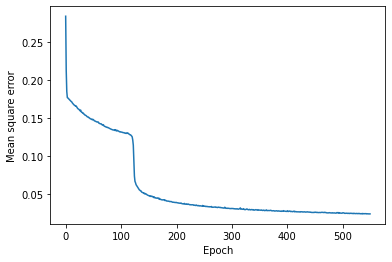

In [19]:
import matplotlib.pyplot as plt  
# evaluate the nn performance 
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean square error')
plt.xlabel('Epoch')
plt.show()


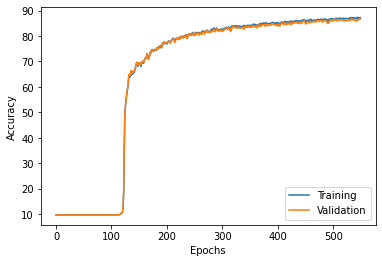

In [20]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
          label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [21]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
test_acc




0.8685